### Evaluate SKlearn Model

In [38]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import ClassifierMixin, RegressorMixin

In [39]:
# Load datasets
X_test = pd.read_csv("../04_modelling/dataset/X_test.csv")
y_test = pd.read_csv("../04_modelling/dataset/y_test.csv").squeeze()    # Convert to Series

In [40]:
# Initialize a DataFrame to store combined model evaluation results
combined_results = pd.DataFrame(columns=["Model", "Framework", "MSE", "RMSE", "MAE", "R2"])

In [41]:
# Function to record evaluation scores
def record_combined_scores(results_df, framework, model_name, **metrics):
    """
    Append evaluation scores to the combined results DataFrame.
    """
    new_row = {
        "Model": model_name,
        "Framework": framework,
        # "Accuracy": metrics.get("Accuracy"),
        # "Precision": metrics.get("Precision"),
        # "Recall": metrics.get("Recall"),
        # "F1_Score": metrics.get("F1_Score"),
        # "AUC_ROC": metrics.get("AUC_ROC"),
        "MSE": metrics.get("MSE"),
        "RMSE": metrics.get("RMSE"),
        "MAE": metrics.get("MAE"),
        "R2": metrics.get("R2")
    }
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
    return results_df

In [42]:
# Function to load scikit-learn models
def load_sklearn_model(file_name):
    with open(file_name, "rb") as file:
        return joblib.load(file)

In [43]:
# Ensure y datasets are flattened
y_test = y_test.values.ravel()

In [44]:
# Evaluate scikit-learn models
def evaluate_sklearn_models(models, X_test, y_test, results_df):
    for model_name, model in models.items():
        try:
            predictions = model.predict(X_test)

            # Compute regression metrics
            mse = mean_squared_error(y_test, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)

            # Record metrics
            results_df = record_combined_scores(
                results_df,
                framework="scikit-learn",
                model_name=model_name,
                MSE=mse,
                RMSE=rmse,
                MAE=mae,
                R2=r2
            )
        except Exception as e:
            print(f"Error evaluating scikit-learn model {model_name}: {e}")
    return results_df

In [45]:
# Define scikit-learn model files
sklearn_model_files = [
    "../04_modelling/models/dtree_model.pkl",
    "../04_modelling/models/mlp_neural_net.pkl",
    "../04_modelling/models/random_forest_model.pkl",
]

In [46]:
# Load scikit-learn models
sklearn_models = {}
for file_name in sklearn_model_files:
    model_name = os.path.splitext(os.path.basename(file_name))[0]
    try:
        sklearn_models[model_name] = load_sklearn_model(file_name)
        print(f"Loaded scikit-learn model: {model_name}")
    except Exception as e:
        print(f"Error loading scikit-learn model {model_name}: {e}")

Loaded scikit-learn model: dtree_model
Loaded scikit-learn model: mlp_neural_net
Loaded scikit-learn model: random_forest_model


In [47]:
# Evaluate scikit-learn models
combined_results = evaluate_sklearn_models(sklearn_models, X_test, y_test, combined_results)

In [48]:
# Display results
# Display and save the evaluation results
print("\SKLearn Model Evaluation Results:")
combined_results

\SKLearn Model Evaluation Results:


,Model,Framework,MSE,RMSE,MAE,R2
0,dtree_model,scikit-learn,9.014530,3.002421,1.467521,0.842866
1,mlp_neural_net,scikit-learn,0.264957,0.514740,0.145299,0.995381
2,random_forest_model,scikit-learn,7.372916,2.715311,1.973631,0.871482


### Evaluate H20 Models

In [52]:
import os
import zipfile
import pandas as pd
import h2o
from h2o.estimators import H2ODeepLearningEstimator
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [53]:
# Initialize H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,34 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 30 days
H2O_cluster_name:,H2O_from_python_Huawei_4u0rbx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.941 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [54]:
# Initialize dictionary to store loaded models
h2o_loaded_models = {}

In [55]:
# Define model files
model_files = [
    "../04_modelling/models/DeepLearning_model_python_1735461052018_31",
    "../04_modelling/models/StackedEnsemble_model_python_1735565212779_5",
    # "../04_modelling/models/voted_ensemble_model.zip"
]

In [56]:
# Function to load H2O models
def load_h2o_model(file_name):
    return h2o.load_model(file_name)

In [57]:
# Function to load a model based on its file type
def load_model(file_name):
    if file_name.endswith(".pkl"):
        return load_sklearn_model(file_name)
    elif file_name.endswith(".zip"):
        # Assuming zip contains a model file
        with zipfile.ZipFile(file_name, "r") as zip_ref:
            zip_ref.extractall("temp_models")
        # Add specific logic for ensemble models here if necessary
        return None  # Placeholder
    else:
        return load_h2o_model(file_name)

In [58]:
# Load all models
for file_name in model_files:
    model_name = os.path.splitext(os.path.basename(file_name))[0]
    try:
        h2o_loaded_models[model_name] = load_model(file_name)
        print(f"Loaded model: {model_name}")
    except Exception as e:
        print(f"Error loading model {model_name}: {e}")

Loaded model: DeepLearning_model_python_1735461052018_31
Loaded model: StackedEnsemble_model_python_1735565212779_5


In [59]:
h2o_loaded_models

{'DeepLearning_model_python_1735461052018_31': Model Details
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_model_python_1735461052018_31


Status of Neuron Layers: predicting yearly_compensation, regression, gaussian distribution, Quadratic loss, 10,251 weights/biases, 138.0 KB, 202,094 training samples, mini-batch size 1
    layer    units    type    dropout              l1                     l2                      mean_rate           rate_rms             momentum    mean_weight             weight_rms            mean_bias              bias_rms
--  -------  -------  ------  -------------------  ---------------------  ----------------------  ------------------  -------------------  ----------  ----------------------  --------------------  ---------------------  -----------------------
    1        50       Input   0.13062179562149737
    2        50       Maxout  0.0                  0.0008734285704456857  0.00044395405309485716  0.4733223503382411  0.11678057909011

In [60]:
# Load datasets
X_test = pd.read_csv("../04_modelling/dataset/X_test.csv")
y_test = pd.read_csv("../04_modelling/dataset/y_test.csv")  # Ensure this is a DataFrame or Series

In [61]:
# Combine X_test and y_test into one DataFrame for H2OFrame
test_df = pd.concat([X_test, y_test], axis=1)
test_h2o = h2o.H2OFrame(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [66]:
# Evaluate H2O models
def evaluate_h2o_models(models, test_h2o, y_test, results_df):
    for model_name, model in models.items():
        try:
            test_performance = model.model_performance(test_data=test_h2o)
            predictions = model.predict(test_h2o).as_data_frame().values.flatten()
            
            # Calculate metrics
            mse = test_performance.mse()
            rmse = test_performance.rmse()
            mae = test_performance.mae()
            r2 = r2_score(y_test, predictions)
            
            print("evaluate_h2o_models", mse, rmse, mae, r2)
            
            print("test_performance", test_performance)
            
            # auc_roc = test_performance.auc() 

            # predictions.auc() 

            # Record metrics
            results_df = record_combined_scores(
                results_df,
                framework="H2O",
                model_name=model_name,
                # Accuracy=None,  # Not applicable for regression
                # Precision=None,
                # Recall=None,
                # F1_Score=None,
                # AUC_ROC=auc_roc,
                MSE=mse,
                RMSE=rmse,
                MAE=mae,
                R2=r2
            )
            
        except Exception as e:
            print(f"Error evaluating H2O model {model_name}: {e}")
    return results_df

In [67]:
combined_results = evaluate_h2o_models(h2o_loaded_models, test_h2o, y_test, combined_results)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\Users\Huawei\OneDrive - Universiti Malaya\Desktop\SEMESTER 7\WIE3007_Data-Mining\Group Project\data-mining-warehousing-wages-analysis\venv\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


evaluate_h2o_models 0.06630532219303646 0.25749819842677824 0.19925882702258896 0.9988442228252492
test_performance ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 0.06630532219303646
RMSE: 0.25749819842677824
MAE: 0.19925882702258896
RMSLE: 0.09276666964802921
Mean Residual Deviance: 0.06630532219303646
                                        Model     Framework       MSE  \
0                                 dtree_model  scikit-learn  9.014530   
1                              mlp_neural_net  scikit-learn  0.264957   
2                         random_forest_model  scikit-learn  7.372916   
3  DeepLearning_model_python_1735461052018_31           H2O  0.066305   

       RMSE       MAE        R2  
0  3.002421  1.467521  0.842866  
1  0.514740  0.145299  0.995381  
2  2.715311  1.973631  0.871482  
3  0.257498  0.199259  0.998844  
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\Users\Huawei\OneDrive - Universiti Malaya\Desktop\SEMESTER 7\WIE3007_Data-Mining\Group Project\data-mining-warehousing-wages-analysis\venv\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


evaluate_h2o_models 0.5516425154961121 0.7427264068929501 0.536177505742845 0.990384243572841
test_performance ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.5516425154961121
RMSE: 0.7427264068929501
MAE: 0.536177505742845
RMSLE: NaN
Mean Residual Deviance: 0.5516425154961121
R^2: 0.990384243572841
Null degrees of freedom: 1169
Residual degrees of freedom: 1167
Null deviance: 67121.28489254977
Residual deviance: 645.4217431304512
AIC: 2632.3357482544166
                                          Model     Framework       MSE  \
0                                   dtree_model  scikit-learn  9.014530   
1                                mlp_neural_net  scikit-learn  0.264957   
2                           random_forest_model  scikit-learn  7.372916   
3    DeepLearning_model_python_1735461052018_31           H2O  0.066305   
4  StackedEnsemble_model_python_1735565212779_5           H2O  0.551643   

       RMSE       MAE        R2  
0  3.002421  1.467521  0

In [68]:
# Display and save the evaluation results
print("\nh2o Model Evaluation Results:")
combined_results


h2o Model Evaluation Results:


,Model,Framework,MSE,RMSE,MAE,R2
0,dtree_model,scikit-learn,9.014530,3.002421,1.467521,0.842866
1,mlp_neural_net,scikit-learn,0.264957,0.514740,0.145299,0.995381
2,random_forest_model,scikit-learn,7.372916,2.715311,1.973631,0.871482
3,DeepLearning_model_python_1735461052018_31,H2O,0.066305,0.257498,0.199259,0.998844
4,StackedEnsemble_model_python_1735565212779_5,H2O,0.551643,0.742726,0.536178,0.990384


In [69]:
# Shutdown H2O Cluster
h2o.cluster().shutdown()

H2O session _sid_8ac5 closed.


In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
# Sort by RMSE
sorted_results = combined_results.sort_values(by="RMSE", ascending=True)
sorted_results

,Model,Framework,MSE,RMSE,MAE,R2
3,DeepLearning_model_python_1735461052018_31,H2O,0.066305,0.257498,0.199259,0.998844
1,mlp_neural_net,scikit-learn,0.264957,0.514740,0.145299,0.995381
4,StackedEnsemble_model_python_1735565212779_5,H2O,0.551643,0.742726,0.536178,0.990384
2,random_forest_model,scikit-learn,7.372916,2.715311,1.973631,0.871482
0,dtree_model,scikit-learn,9.014530,3.002421,1.467521,0.842866


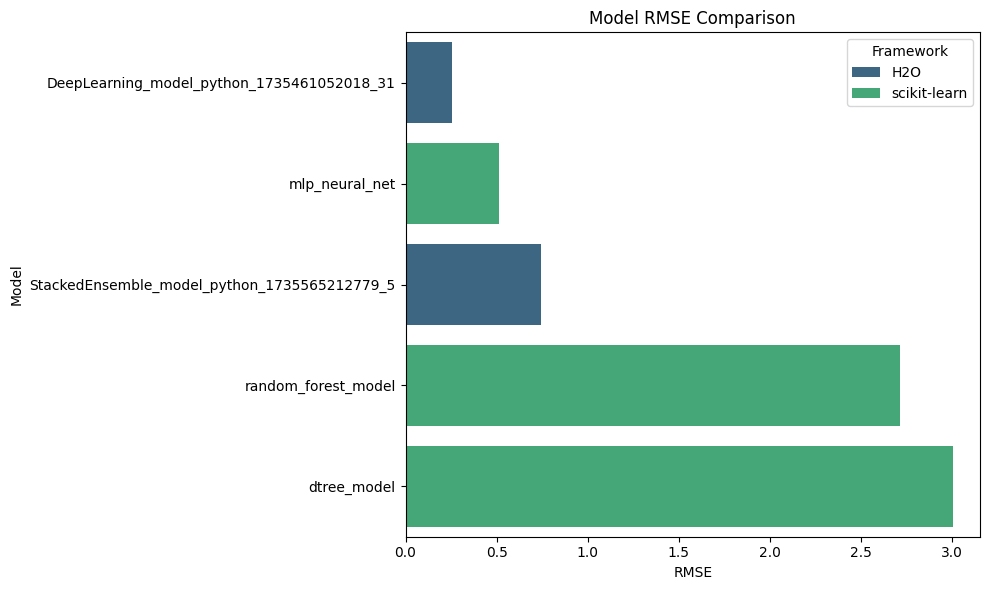

In [72]:
# Visualize RMSE
plt.figure(figsize=(10, 6))
sns.barplot(data=sorted_results, x="RMSE", y="Model", hue="Framework", palette="viridis")
plt.title("Model RMSE Comparison")
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.legend(title="Framework")
plt.tight_layout()
plt.show()

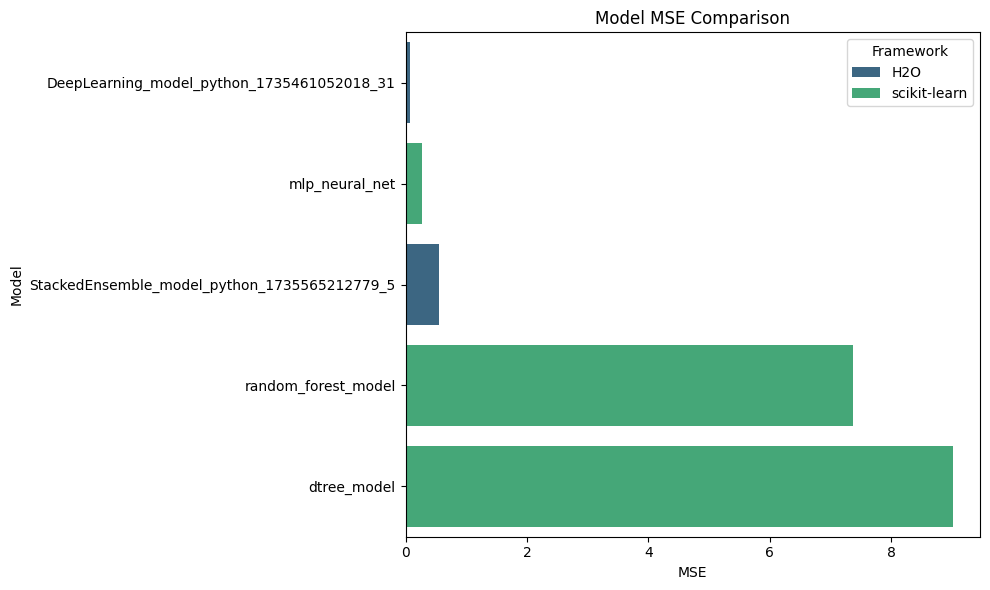

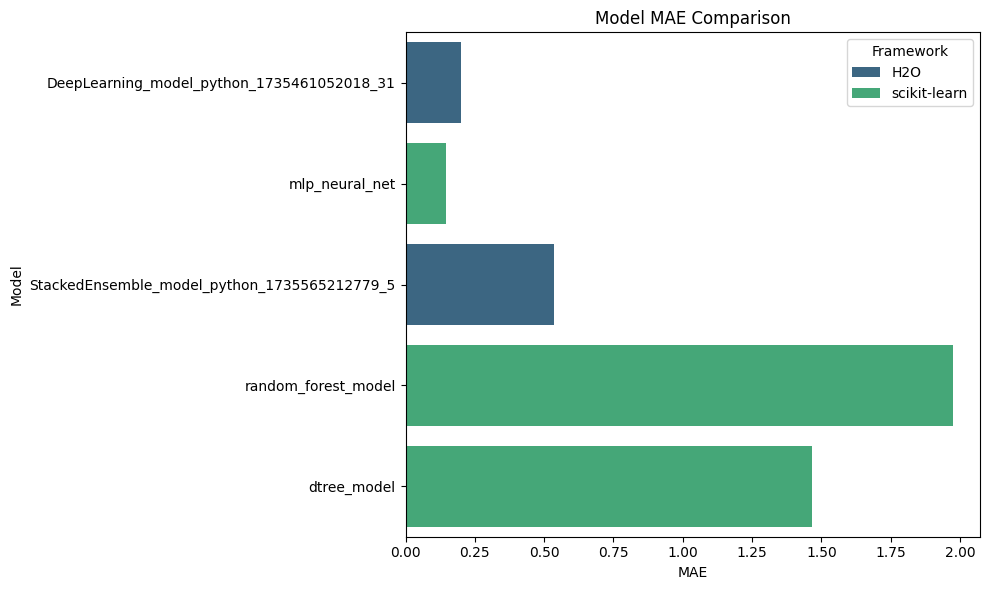

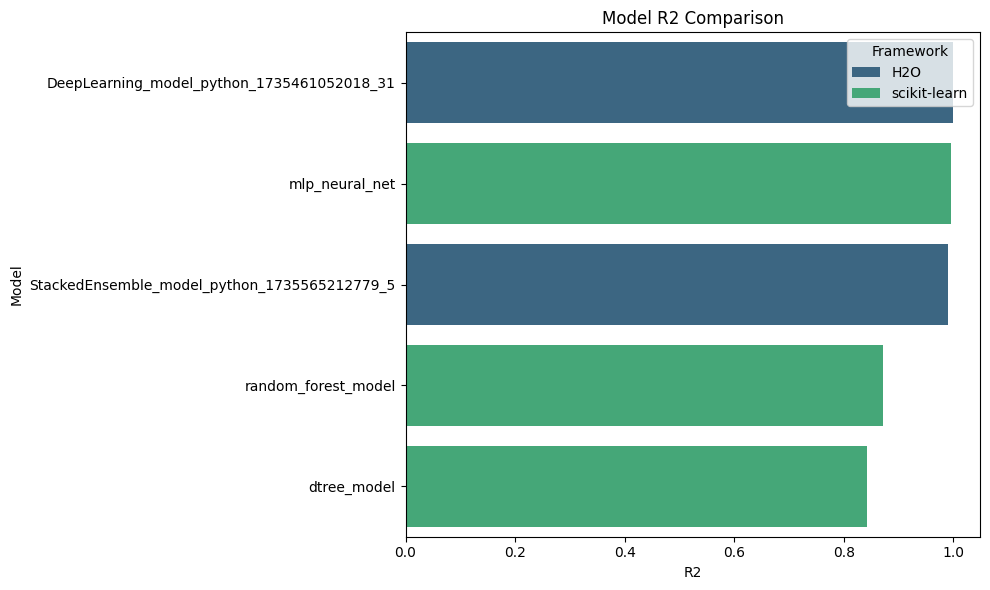

In [73]:
# Visualize other metrics
metrics = ["MSE", "MAE", "R2"]
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=sorted_results, x=metric, y="Model", hue="Framework", palette="viridis")
    plt.title(f"Model {metric} Comparison")
    plt.xlabel(metric)
    plt.ylabel("Model")
    plt.legend(title="Framework")
    plt.tight_layout()
    plt.show()

In [74]:
# Final Model Selection Justification
best_model = sorted_results.iloc[0]  # Select the model with the lowest RMSE
print("Selected Model for Deployment:")
print(best_model)

Selected Model for Deployment:
Model        DeepLearning_model_python_1735461052018_31
Framework                                           H2O
MSE                                            0.066305
RMSE                                           0.257498
MAE                                            0.199259
R2                                             0.998844
Name: 3, dtype: object
